### Import Necessary Libraries

In [1]:
import pandas as pd
import seaborn as sns
from numpy import sqrt
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

### Import Dataset

In [2]:
airline_data=pd.read_excel('Airlines+Data.xlsx')
airline_data['Month']

0    1995-01-01
1    1995-02-01
2    1995-03-01
3    1995-04-01
4    1995-05-01
        ...    
91   2002-08-01
92   2002-09-01
93   2002-10-01
94   2002-11-01
95   2002-12-01
Name: Month, Length: 96, dtype: datetime64[ns]

### Data Understanding

In [3]:
airline_data.shape

(96, 2)

In [4]:
airline_data.isna().sum()

Month         0
Passengers    0
dtype: int64

In [5]:
airline_data.dtypes

Month         datetime64[ns]
Passengers             int64
dtype: object

### Data visualization

<AxesSubplot:>

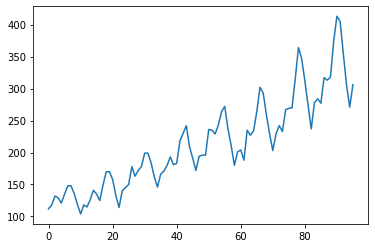

In [6]:
airline_data['Passengers'].plot()

<AxesSubplot:>

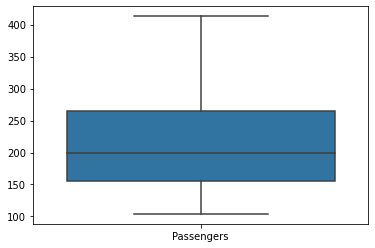

In [7]:
sns.boxplot(data=airline_data)

<AxesSubplot:>

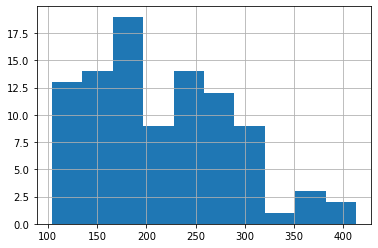

In [8]:
airline_data['Passengers'].hist()

<AxesSubplot:ylabel='Density'>

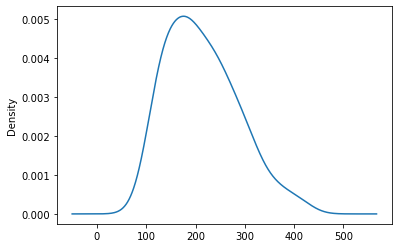

In [9]:
airline_data['Passengers'].plot(kind='kde')

<AxesSubplot:xlabel='y(t)', ylabel='y(t + 1)'>

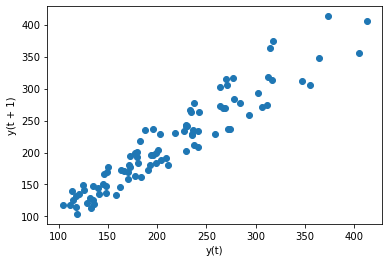

In [10]:
from pandas.plotting import lag_plot

lag_plot(airline_data['Passengers'])

### Data driven modelling

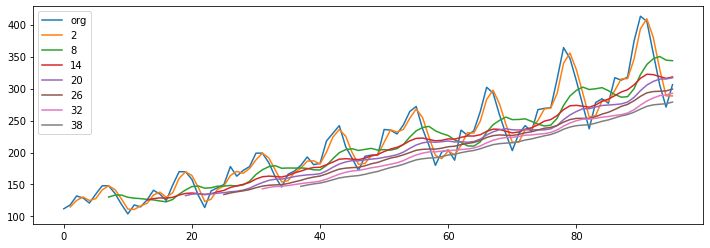

In [11]:
plt.figure(figsize=(12,4))
airline_data['Passengers'].plot(label="org")
for i in range(2,40,6):
    airline_data['Passengers'].rolling(i).mean().plot(label=str(i))
plt.legend(loc='best')

### Decomposition plot

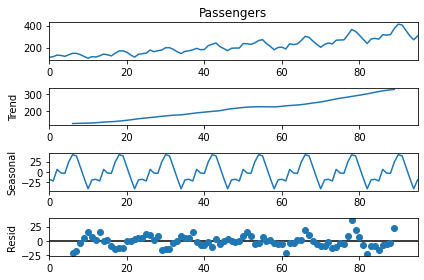

In [12]:
from statsmodels.tsa.seasonal import seasonal_decompose

decompose_ts_add = seasonal_decompose(airline_data['Passengers'],period=12)
decompose_ts_add.plot()
plt.show()

### ACF and PACF plots

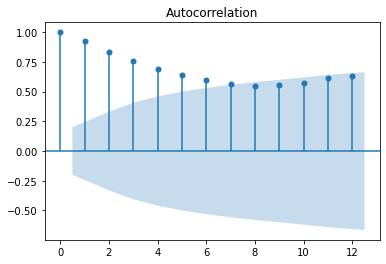

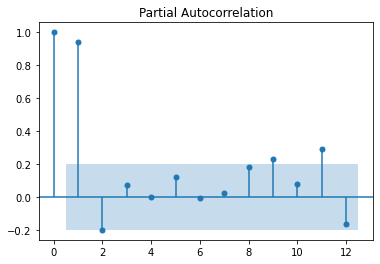

In [13]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
plot_acf(airline_data['Passengers'],lags=12)
plot_pacf(airline_data['Passengers'],lags=12)
plt.show()

### Simple exponential method

In [14]:
train=airline_data.head(80)
test=airline_data.tail(15)

In [15]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing,Holt,ExponentialSmoothing
import numpy as np
from sklearn.metrics import mean_absolute_percentage_error

In [16]:
ses_model = SimpleExpSmoothing(train["Passengers"]).fit(smoothing_level=0.2)
pred_ses = ses_model.predict(start = test.index[0],end = test.index[-1])
ses_rms=mean_absolute_percentage_error(pred_ses,test['Passengers'])*100 
ses_rms

13.30708940108742

### Holt's Method

In [17]:
ht_model = Holt(train["Passengers"]).fit(smoothing_level=0.8, smoothing_slope=0.2)
pred_ht = ht_model.predict(start = test.index[0],end = test.index[-1])
ht_rms=mean_absolute_percentage_error(pred_ht,test['Passengers'])*100 
ht_rms

33.89294255735527

### Holts winter exponential smoothing with multiplicative seasonality and additive trend

In [18]:
hwe_model_mul_add = ExponentialSmoothing(train["Passengers"],seasonal="mul",trend="add",seasonal_periods=12).fit() 
pred_hwe_mul_add = hwe_model_mul_add.predict(start = test.index[0],end = test.index[-1])
hw_ma_rms=mean_absolute_percentage_error(pred_hwe_mul_add,test['Passengers'])*100 
hw_ma_rms

3.5736395553363747

### Holts winter exponential smoothing with additive seasonality and additive trend

In [19]:
hwe_model_add_add = ExponentialSmoothing(train["Passengers"],seasonal="add",trend="add",seasonal_periods=12).fit() #add the trend to the model
pred_hwe_add_add = hwe_model_add_add.predict(start = test.index[0],end = test.index[-1])

hw_aa_rms=mean_absolute_percentage_error(pred_hwe_add_add,test['Passengers'])*100 
hw_aa_rms

7.653523863906539

### ARMA Model

In [20]:
from statsmodels.tsa.arima_model import ARMA,ARIMA

In [21]:
arma_model = ARMA(train['Passengers'], order=(1, 1)) #model with AR=0 and MA=1
arma_model_fit = arma_model.fit()

arma_pred = arma_model_fit.predict(0,14)
arma_pred

arma_rms=mean_absolute_percentage_error(arma_pred,test['Passengers'])*100 
arma_rms

139.12501019861193

### ARIMA Model

In [22]:
arima_model = ARIMA(train['Passengers'], order=(1, 1, 2)) #notice p,d and q value here
arima_model_fit = arima_model.fit()

arima_pred = arima_model_fit.predict(1,15,typ='levels')

arima_rms=mean_absolute_percentage_error(arima_pred,test['Passengers'])*100
arima_rms

143.75870966636268

### Converting non stationary data to stationary data to improve ARIMA model

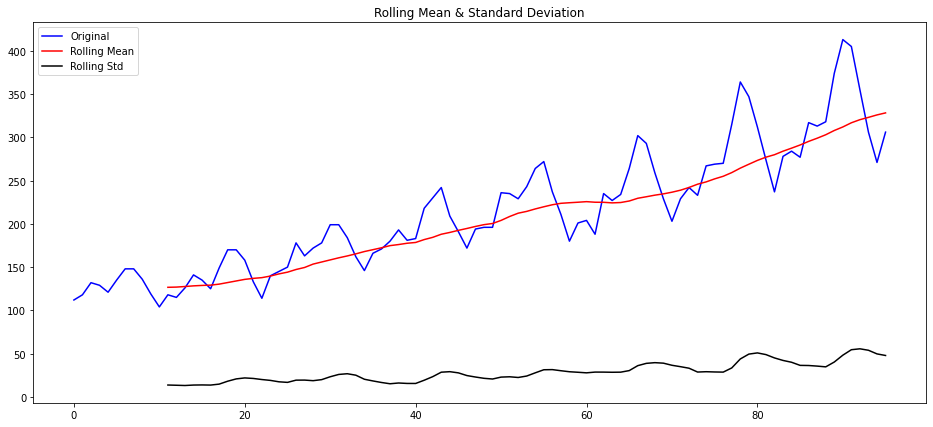

In [23]:
roll_mean = airline_data['Passengers'].rolling(12).mean() # 12 entries
roll_std = airline_data['Passengers'].rolling(12).std()

plt.figure(figsize=(16,7))
fig = plt.figure(1)

#Plot rolling statistics:
orig = plt.plot(airline_data['Passengers'], color='blue',label='Original')
mean = plt.plot(roll_mean, color='red', label='Rolling Mean')
std = plt.plot(roll_std, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

### Making stationary

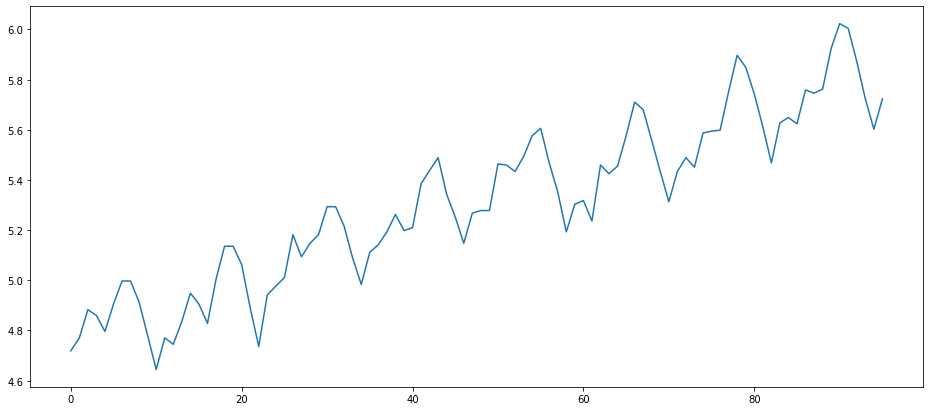

In [24]:
plt.figure(figsize=(16,7))
fig = plt.figure(1)

import numpy as np
ts_log = np.log(airline_data['Passengers'])#to transform to stationary from non-stationary
plt.plot(ts_log)

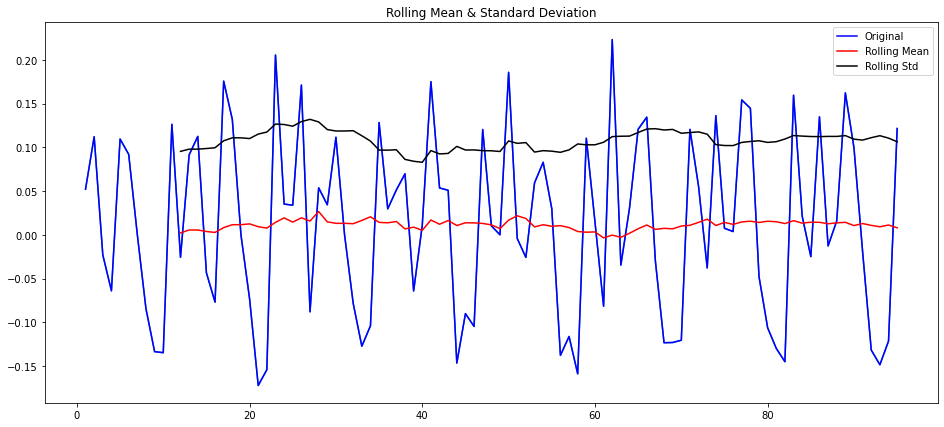

In [25]:
plt.figure(figsize=(16,7))
fig = plt.figure(1)
ts_log_diff = ts_log - ts_log.shift() # I will shift the time series by 1 and subtract from the original TS.
plt.plot(ts_log_diff)

#Determing rolling statistics
roll_mean = ts_log_diff.rolling(12).mean()
roll_std = ts_log_diff.rolling(12).std()




#Plot rolling statistics:
orig = plt.plot(ts_log_diff, color='blue',label='Original')
mean = plt.plot(roll_mean, color='red', label='Rolling Mean')
std = plt.plot(roll_std, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

### ACF , PACF Plot

In [26]:
from statsmodels.tsa.stattools import acf, pacf
lag_acf = acf(ts_log_diff, nlags=12)
lag_pacf = pacf(ts_log_diff, nlags=12)

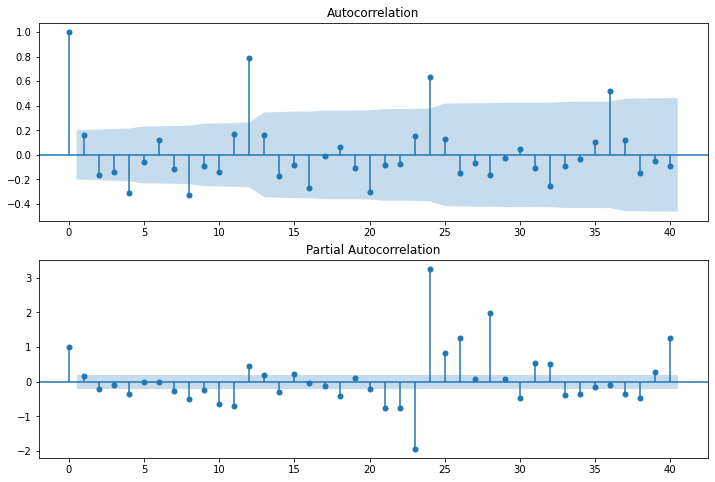

In [27]:
import statsmodels.api as sm
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(ts_log_diff.dropna(),lags=40,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(ts_log_diff.dropna(),lags=40,ax=ax2)

In [28]:
ts_log_diff = ts_log_diff[~ts_log_diff.isnull()]

C:\Users\shash\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
C:\Users\shash\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
C:\Users\shash\anaconda3\lib\site-packages\statsmodels\base\model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


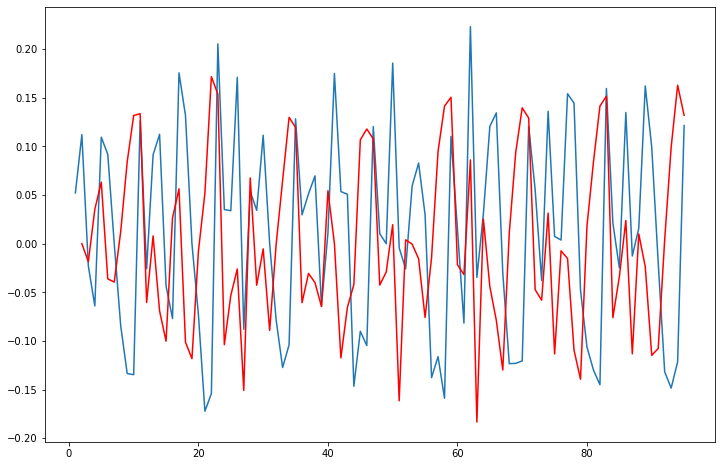

In [29]:
plt.figure(figsize=(12,8))
ts_log_diff.dropna(inplace=True)
model = ARIMA(ts_log_diff, order=(4,1,2))  
results_ARIMA = model.fit()  
plt.plot(ts_log_diff)
plt.plot(results_ARIMA.fittedvalues, color='red')

### Model Based Forecasting

In [31]:
airline_data_model=airline_data

In [32]:
airline_data_model

,Month,Passengers
0,1995-01-01,112
1,1995-02-01,118
2,1995-03-01,132
3,1995-04-01,129
4,1995-05-01,121
...,...,...
91,2002-08-01,405
92,2002-09-01,355
93,2002-10-01,306
94,2002-11-01,271


In [33]:
airline_data_model['Month']=airline_data_model['Month'].astype('str')

In [34]:
airline_data_model['Year']=0
for i in range(len(airline_data_model)):
    p=airline_data_model['Month'][i]
    airline_data_model['Year'][i]=p[0:4]

In [35]:
airline_data_model['Months']=0
for i in range(len(airline_data_model)):
    p=airline_data_model['Month'][i]
    airline_data_model['Months'][i]=p[5:7]

In [36]:
airline_data_model

,Month,Passengers,Year,Months
0,1995-01-01,112,1995,1
1,1995-02-01,118,1995,2
2,1995-03-01,132,1995,3
3,1995-04-01,129,1995,4
4,1995-05-01,121,1995,5
...,...,...,...,...
91,2002-08-01,405,2002,8
92,2002-09-01,355,2002,9
93,2002-10-01,306,2002,10
94,2002-11-01,271,2002,11


In [37]:
dummies = pd.DataFrame(pd.get_dummies(airline_data_model['Months']))

In [38]:
airlines_df =pd.concat([airline_data_model,dummies],axis= 1)
airlines_df

,Month,Passengers,Year,Months,1,2,3,4,5,6,7,8,9,10,11,12
0,1995-01-01,112,1995,1,1,0,0,0,0,0,0,0,0,0,0,0
1,1995-02-01,118,1995,2,0,1,0,0,0,0,0,0,0,0,0,0
2,1995-03-01,132,1995,3,0,0,1,0,0,0,0,0,0,0,0,0
3,1995-04-01,129,1995,4,0,0,0,1,0,0,0,0,0,0,0,0
4,1995-05-01,121,1995,5,0,0,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,2002-08-01,405,2002,8,0,0,0,0,0,0,0,1,0,0,0,0
92,2002-09-01,355,2002,9,0,0,0,0,0,0,0,0,1,0,0,0
93,2002-10-01,306,2002,10,0,0,0,0,0,0,0,0,0,1,0,0
94,2002-11-01,271,2002,11,0,0,0,0,0,0,0,0,0,0,1,0


In [39]:
airlines_df['tsquare']=airlines_df['Months'].apply(lambda x:x**2)

In [40]:
from numpy import log
airlines_df['log_passengers']=airlines_df['Passengers'].apply(lambda x:log(x))

In [41]:
airlines_df

,Month,Passengers,Year,Months,1,2,3,4,5,6,7,8,9,10,11,12,tsquare,log_passengers
0,1995-01-01,112,1995,1,1,0,0,0,0,0,0,0,0,0,0,0,1,4.718499
1,1995-02-01,118,1995,2,0,1,0,0,0,0,0,0,0,0,0,0,4,4.770685
2,1995-03-01,132,1995,3,0,0,1,0,0,0,0,0,0,0,0,0,9,4.882802
3,1995-04-01,129,1995,4,0,0,0,1,0,0,0,0,0,0,0,0,16,4.859812
4,1995-05-01,121,1995,5,0,0,0,0,1,0,0,0,0,0,0,0,25,4.795791
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,2002-08-01,405,2002,8,0,0,0,0,0,0,0,1,0,0,0,0,64,6.003887
92,2002-09-01,355,2002,9,0,0,0,0,0,0,0,0,1,0,0,0,81,5.872118
93,2002-10-01,306,2002,10,0,0,0,0,0,0,0,0,0,1,0,0,100,5.723585
94,2002-11-01,271,2002,11,0,0,0,0,0,0,0,0,0,0,1,0,121,5.602119


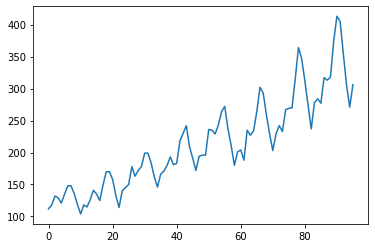

In [42]:
import matplotlib.pyplot as plt
plt.plot(airlines_df['Passengers'])

In [43]:
airlines_df=airlines_df.rename(columns={1:'jan',2:'feb',3:'mar',4:'apr',5:'may',6:'jun',7:'july',8:'aug',9:'sep',10:'oct',11:'nov',12:'dec'})

In [44]:
train_model=airlines_df.head(80)
test_model=airlines_df.tail(15)

In [45]:
import statsmodels.formula.api as smf 
from sklearn.metrics import mean_absolute_percentage_error

### Linear Model

In [46]:
linear_model = smf.ols('Passengers~Months',data=train_model).fit()
linear_pred=linear_model.predict(test_model['Months'])

linear_rms=mean_absolute_percentage_error(test_model['Passengers'],linear_pred)*100
linear_rms

37.135626863293915

### Exponential Model

In [47]:
exponential_model = smf.ols('log_passengers~Months',data=train_model).fit()
exponential_pred=exponential_model.predict(test_model['Months'])

exp_rms=mean_absolute_percentage_error(test_model['Passengers'],exponential_pred)*100
exp_rms

98.30419643524579

In [53]:
quaratic_model = smf.ols('Passengers~(Months+tsquare)',data=train_model).fit()
#quaratic_model.fit()
quaratic_pred=quaratic_model.predict(test_model[['Months','tsquare']])

qua_rms=mean_absolute_percentage_error(test_model['Passengers'],quaratic_pred)*100

In [48]:
add_sea = smf.ols("Passengers~jan+feb+mar+apr+may+jun+july+aug+sep+oct+nov+dec",data=train_model).fit()
add_pred=add_sea.predict(test_model[['jan','feb','mar','apr','may','jun','july','aug','sep','oct','nov','dec']])

add_rms=mean_absolute_percentage_error(test_model['Passengers'],add_pred)*100
add_rms

40.28314165835846

In [49]:
add_qua_model=smf.ols("Passengers~Months+tsquare+jan+feb+mar+apr+may+jun+july+aug+sep+oct+nov+dec",data=train_model).fit()
add_qua_pred=add_qua_model.predict(test_model[['Months','tsquare','jan','feb','mar','apr','may','jun','july','aug','sep','oct','nov','dec']])

add_qua_rms=mean_absolute_percentage_error(test_model['Passengers'],add_qua_pred)*100
add_qua_rms

40.28314165837223

In [50]:
mul_sea = smf.ols("log_passengers~jan+feb+mar+apr+may+jun+july+aug+sep+oct+nov+dec",data=train_model).fit()
mul_pred=mul_sea.predict(test_model[['jan','feb','mar','apr','may','jun','july','aug','sep','oct','nov','dec']])

mul_rms=mean_absolute_percentage_error(test_model['Passengers'],mul_pred)*100
mul_rms

98.31984707397673

In [51]:
mul_add_model=smf.ols("Passengers~Months+jan+feb+mar+apr+may+jun+july+aug+sep+oct+nov+dec",data=train_model).fit()
mul_add_pred=mul_add_model.predict(test_model[['Months','jan','feb','mar','apr','may','jun','july','aug','sep','oct','nov','dec']])

mul_add_rms=mean_absolute_percentage_error(test_model['Passengers'],mul_add_pred)*100
mul_add_rms

40.283141658358446

In [55]:
data = {"MODEL":pd.Series(["rmse_linear","rmse_Exp","rmse_Quad","rmse_add_sea","rmse_add_sea_quad","rmse_Mult_sea","rmse_Mult_add_sea",'rmse_ses','rmse_holt','rmse_holt_ma','rmse_holt_aa','rmse_arma','rmse_arima']),
        "RMSE_Values":pd.Series([linear_rms,exp_rms,qua_rms,add_rms,add_qua_rms,mul_rms,mul_add_rms,ses_rms,ht_rms,hw_ma_rms,hw_aa_rms,arma_rms,arima_rms])}
table_rmse=pd.DataFrame(data)
table_rmse.sort_values(['RMSE_Values'])

,MODEL,RMSE_Values
9,rmse_holt_ma,3.573640
10,rmse_holt_aa,7.653524
7,rmse_ses,13.307089
8,rmse_holt,33.892943
0,rmse_linear,37.135627
2,rmse_Quad,39.211566
6,rmse_Mult_add_sea,40.283142
3,rmse_add_sea,40.283142
4,rmse_add_sea_quad,40.283142
1,rmse_Exp,98.304196


### Final Model

In [56]:
hwe_model_mul_add = ExponentialSmoothing(train["Passengers"],seasonal="mul",trend="add",seasonal_periods=12).fit() 

In [57]:
hwe_model_mul_add.forecast(10)

80    310.167468
81    273.378279
82    239.338290
83    270.781932
84    276.720500
85    274.058000
86    317.641288
87    307.796417
88    306.485055
89    343.879735
dtype: float64